## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib import colors
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Taking hue 
plt.show()

In [3]:
#Read Data and create Dataframe

df = pd.read_csv('bike_share_data.csv')

In [4]:
#check dataframe

df.head()

,date,rides,temperature,weather
0,1/1/2014,95,19.483158,rain or snow
1,1/2/2014,111,16.833333,rain or snow
2,1/3/2014,6,-5.633333,clear
3,1/4/2014,181,30.007735,rain or snow
4,1/5/2014,32,16.756250,rain or snow


In [5]:
#We will use Date & Rides variables for Forecasting

df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

In [6]:
df.head(1)

,ds,y
0,2014-01-01,95


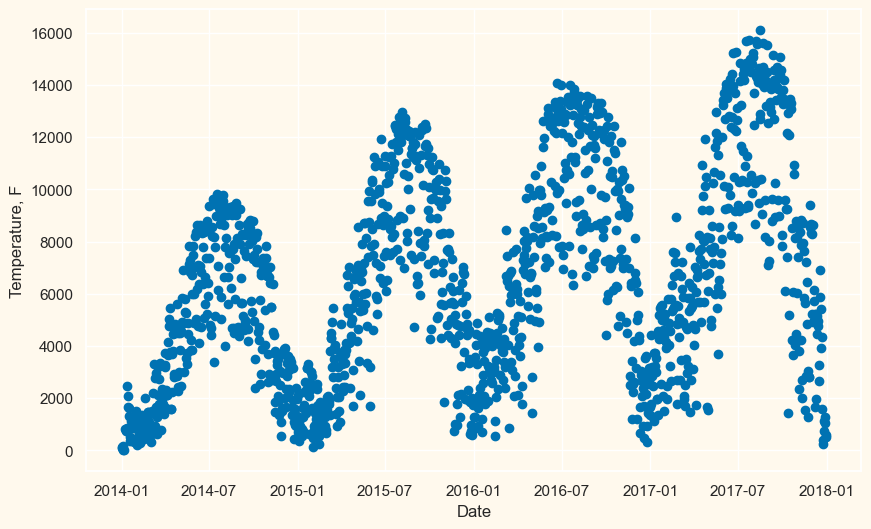

In [7]:
#plotting 

plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'], c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Temperature, F')
plt.show()

In [8]:
#Our Max date is 2018 we will be predicting for 2018
df['ds'].max()

Timestamp('2017-12-31 00:00:00')

## 2. Create Holiday Dataframe

In [9]:
#Bike share Data is from Chicago, and this will help us in creating a holiday dataframe with Illinois local holiday

from prophet.make_holidays import make_holidays_df

### 2.1 Year 2017 + Additional year 2018 as future Data

In [10]:
# Identify the final year, as an integer, and increase it by 1
year_list = df['ds'].dt.year.unique().tolist()

year_list.append(year_list[-1] + 1)

In [11]:
#Initial Holiday Dataframe consist of US and State level Holidays

holidays = make_holidays_df(year_list=year_list,
                            country='US',
                            state='IL')

holidays.head()

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-12,Lincoln's Birthday
3,2016-02-15,Washington's Birthday
4,2016-03-07,Casimir Pulaski Day


### 2.2 Add Additional Holidays 

In [12]:
# Prior Scale options lets us do Regularization, which prevents its from overfitting. 

black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(['2014-11-28',
                                                   '2015-11-27',
                                                   '2016-11-25',
                                                   '2017-11-24',
                                                   '2018-11-23']),
                             'prior_scale': 1})

christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(['2014-12-24',
                                                    '2015-12-24',
                                                    '2016-12-24',
                                                    '2017-12-24',
                                                    '2018-12-24']),
                              'prior_scale': 1})

### 2.3 Add Holidays with Upper and Lower Windows

In [13]:
#Taste of Chicago is a local food festival. 
#lower window to 0 and upper window to 4 we are anticpating the demand to last 4 days since the start of Festival


taste_of_chicago = pd.DataFrame({'holiday': 'Taste of Chicago',
                                 'ds': pd.to_datetime(['2014-07-09',
                                                       '2015-07-08',
                                                       '2016-07-06',
                                                       '2017-07-05',
                                                       '2018-07-11']),
                                 'lower_window': 0,
                                 'upper_window': 4,
                                 'prior_scale': 10})

In [14]:
#Combine all Holidays together to create a dataframe

holidays = pd.concat([holidays, taste_of_chicago]
                    ).sort_values('ds').reset_index(drop=True)

In [15]:
holidays.head()

,ds,holiday,lower_window,upper_window,prior_scale
0,2014-01-01,New Year's Day,NaN,NaN,NaN
1,2014-01-20,Martin Luther King Jr. Day,NaN,NaN,NaN
2,2014-02-12,Lincoln's Birthday,NaN,NaN,NaN
3,2014-02-17,Washington's Birthday,NaN,NaN,NaN
4,2014-03-03,Casimir Pulaski Day,NaN,NaN,NaN


## 3. Prophet Model

In [16]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays,
               holidays_prior_scale = 10)

In [17]:
model.fit(df)

17:12:14 - cmdstanpy - INFO - Chain [1] start processing
17:12:15 - cmdstanpy - INFO - Chain [1] done processing


## 4. Vizualize the Forecast

In [18]:
#create future dataframe
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

### 4.1 Forecast for 2018

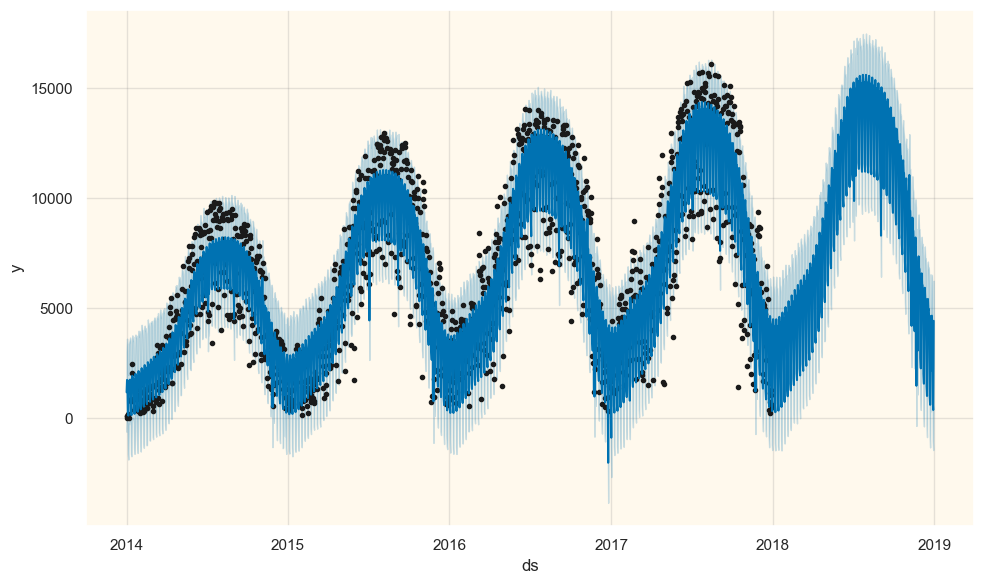

In [19]:
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

### 4.2 Plot components
Structural Time Series decomposition

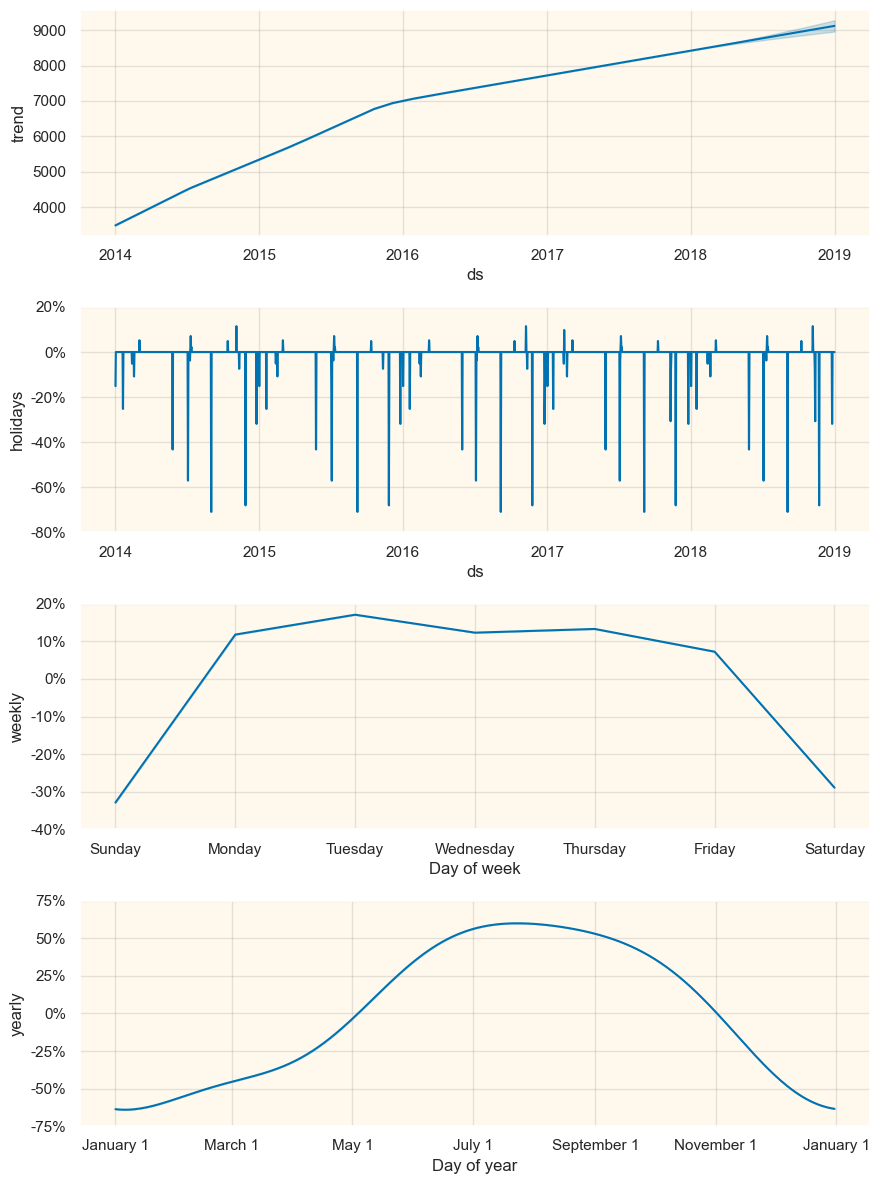

In [20]:
fig2 = model.plot_components(forecast)
plt.show()

### 4.3 Demand During Holidays

In [21]:
from prophet.plot import plot_forecast_component

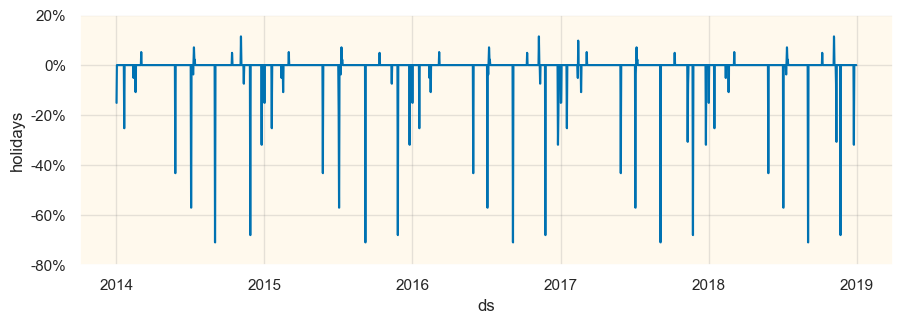

In [22]:
fig = plot_forecast_component(model,
                              forecast,
                              'holidays',
                              figsize=(10.5, 3.25))
plt.show()

In [23]:
def first_non_zero(fcst, holiday):
    return fcst[fcst[holiday] != 0][holiday].values[0]

pd.DataFrame({'holiday': model.train_holiday_names,
              'effect': [first_non_zero(forecast, holiday)
                         for holiday in model.train_holiday_names]})

,holiday,effect
0,New Year's Day,-0.150984
1,Martin Luther King Jr. Day,-0.252331
2,Lincoln's Birthday,-0.051556
3,Washington's Birthday,-0.108042
4,Casimir Pulaski Day,0.052062
5,Memorial Day,-0.431948
6,Independence Day,-0.569870
7,Taste of Chicago,-0.037358
8,Labor Day,-0.708523
9,Columbus Day,0.048895


### 4.4 Forecast For 'Taste of Chicago'

In [24]:
forecast[forecast['ds'].isin(['2018-07-11',
                              '2018-07-12',
                              '2018-07-13',
                              '2018-07-14',
                              '2018-07-15']
                            )][['ds',
                                'Taste of Chicago']]

,ds,Taste of Chicago
1649,2018-07-11,-0.037358
1650,2018-07-12,0.021078
1651,2018-07-13,0.070867
1652,2018-07-14,0.015254
1653,2018-07-15,0.021823


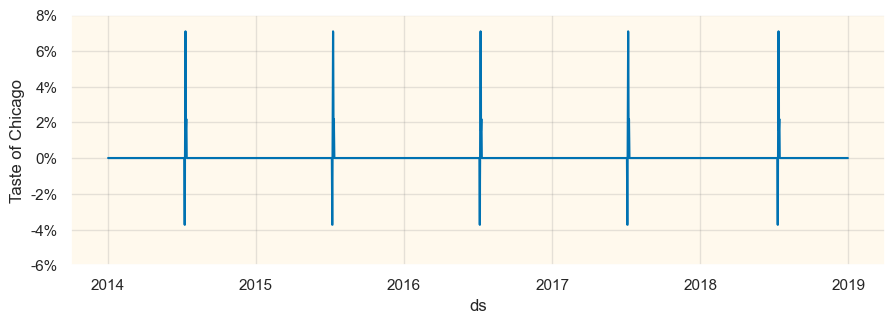

In [25]:
fig3 = plot_forecast_component(model,
                               forecast,
                               'Taste of Chicago',
                               figsize=(10.5, 3.25))
plt.show()